# MAIN

In [3]:
import pandas as pd
from zipfile import ZipFile
import csv
import json
import os
import time as t
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime

In [ ]:
def getcoordinates(data):
    if data and len(data["coordinates"]) == 2:
        return data["coordinates"][0], data["coordinates"][1]
    return np.nan,np.nan    

def getmention(data):
    ids, handles = "", ""
    # all the user ids and their handles and concatinated into a string with a seperator
    for d in data['user_mentions']:
        ids += d["id_str"]+"/"
        handles += "#"+d['screen_name']
    return ids, handles    

def gethashtags(data):
    tags = ""
    # all the hastags are concatinated into one string with a hash as a seperator
    for d in data['hashtags']:
        tags += "#"+d["text"]      
    return tags  

def getcountry(data):
    if data:
        if data["country_code"]:
            if len(data["country_code"])>0:
                return data["country_code"]
    return np.nan

def getdiagonal(data):
    if data and data['bounding_box']['coordinates']:
        x1=data['bounding_box']['coordinates'][0][0][0]
        y1=data['bounding_box']['coordinates'][0][0][1]
        x2=data['bounding_box']['coordinates'][0][3][0]
        y2=data['bounding_box']['coordinates'][0][3][1]
        p1=np.array((x1,y1))
        p2=np.array((x2,y2))
        distance = np.linalg.norm(p1-p2)
        return distance
    return np.nan

def gettext(data):
    if data:
        if len(data)>0:
            return data
    return np.nan


def hashtags(series_values):
    '''
    Generates a list of hashtags from series of hashtag data of tweets
    series_values: pandas series from dataframe
    hashtags_final: python list of hashtags
    '''
    hashtags = list(series_values)
    hashtags_final = []
    for i in hashtags:
        if type(i) == list:
            hashtags_final.extend(i)
    return hashtags_final


import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im

def make_wordcloud(data_list,mask_image_path,title,processed,max_words):
    #Create a string form of our list of text
    if processed is False:  # Check if input data is already not a list of words, that is not processed already.
        raw_string = ''.join(data_list)
        no_links = re.sub(r'http\S+', '', raw_string) # remove http links
        no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links) # remove unicode characters
        no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode) # remove secial characters

        #words = no_special_characters.split(" ")
        words = no_special_characters.split(" ")
        words = [w for w in words if len(w) > 2]  # ignore a, an, be, ...
        words = [w.lower() for w in words]
        words = [w for w in words if w not in STOPWORDS]
    else: # if already a list of words, then string processing not needed.
        words = [w for w in data_list if len(w) > 2]  # ignore a, an, be, ...
        words = [w.lower() for w in words]
        words = [w for w in words if w not in STOPWORDS]
        
    mask = np.array(Image.open(mask_image_path))
    wc = WordCloud(background_color="white", max_words=max_words, mask=mask)
    clean_string = ','.join(words)
    wc.generate(clean_string)

    f = plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
tweets, zip_list2=[],[]
count=0
#path=r"C:\\Users\\Harshita\\Exeter\\Introduction to DS\\Coursework\\11\\New folder\\Testing_1\"
pathos = "C://Users//Harshita//Exeter//Introduction to DS//Coursework//11//New folder//Testing_1//Ext"
zip_list = os.listdir(pathos)

path=r"C:\\Users\\Harshita\\Exeter\\Introduction to DS\\Coursework\\11\\New folder\\Testing_1\\Ext"

for i in zip_list:
    zip_list2.append((f"{path}/{i}").replace("\\\\","/"))
#print(len(zip_list2))
start = t.time()
print("Time started for making a CSV")

for i in zip_list2:
    data, ids = {}, []
    with ZipFile(f"{i}") as myzip:
        for filenames in myzip.namelist():
            with myzip.open(filenames) as f:
                for y in f:
                    d=json.loads(y)
                    if "id" in d:
                        ids.append(d["id_str"])
                        long , lat = getcoordinates(d['coordinates'])
                        mention, m_han= getmention(d['entities'])
                        tags = gethashtags(d['entities'])
                        diagonal_len = getdiagonal(d['place'])
                        cntry_cd = getcountry(d['place'])
                        text1 = gettext(d['text'])
                        data={
                            "tid":d["id_str"],
                            "lang":d['lang'],
                            "timestamp":d['timestamp_ms'],
                            "long" : long,
                            "lat" : lat,
                            "userid" : d['user']['id'],
                            "handle" : d['user']['screen_name'],
                            "mention": mention,
                            "m_han": m_han,
                            "cntry_cd" : cntry_cd,
                            "diagonal_len" : diagonal_len,
                            "texts" : text1.encode('ascii', 'replace'),
                            "tags" : tags.encode('ascii', 'replace')   
                        }

                        csv_columns = ['tid','lang','timestamp','long','lat','userid','handle','mention','m_han','cntry_cd','diagonal_len','texts','tags']
                        
                        #csv_columns = ['tid','lang','times','long','lat','userid','handel','mention','m_han','tags','pmin','pmax']
                        csv_file = filenames[10:30]+".csv"
                        #print(csv_file)
                        try:
                            if count==0:
                                count=1
                                with open(csv_file, 'w') as csvfile:
                                    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                                    writer.writeheader()
                                    writer.writerow(data)
                                    csvfile.close()
                            else:
                                count+=1
                                with open(csv_file, 'a') as csvfile:
                                    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                                    writer.writerow(data)
                                    csvfile.close()
                        except IOError:
                            print("I/O error")


end = t.time()
print("time ended in sec : ", end - start)
print("time ended in mins : ",((end - start)/60))
print("time ended in hrs : ",((end - start)/3600))
print("Time ended for making a CSV")
print(type(d),len(d))

In [4]:
##CREATING A DATAFRAME

files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/"

k=[]
for f in files:
    m=directory+f
    k.append(m)

df = pd.concat(map(pd.read_csv, k))
len(df)
df2=df.drop_duplicates()
df2







temp_list = [datetime.utcfromtimestamp(i/1000) for i in df2['timestamp'].values]
df2.insert(3, "ts", temp_list, True)

In [ ]:
##QUESTION 1.1 : 15033548

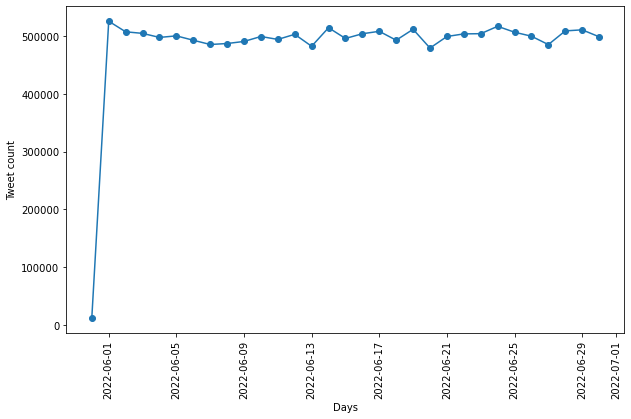

In [136]:
##QUESTION 1.2
# temp_list = [datetime.fromtimestamp(i/1000) for i in df2['timestamp'].values]
# df2.insert(3, "ts", temp_list, True)
df3 = df2.groupby(pd.to_datetime(df2['ts']).dt.date)['timestamp'].agg('count').reset_index()

rcParams['figure.figsize']=10,6
plt.scatter(df3.ts, df3.timestamp)
plt.plot(df3.ts, df3.timestamp)
plt.xticks(rotation = 90)
plt.xlabel("Days")
plt.ylabel("Tweet count")
plt.show()

In [ ]:
##QUESTION 1.3
import seaborn as sns
days = []
for i in range(1,721):
    if i % 7 == 0 or i % 7 == 1:
        days.append("Weekend")
    else:
        days.append("Weekday")
sns.reset_defaults() 
plt.style.use("seaborn-whitegrid")
sns.boxplot(x=days, y=tweets_day)
plt.ylabel("No of Tweets")
plt.savefig("task1e.png")
plt.show()

In [138]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/"

def taskOne(files):
    
    tweets_day = []
    lang_count = Counter()
    t_hour = []
   
    for f in files:
    
        df = pd.read_csv(directory+f)
        # Task 1.2, 1.3, 1.5 storing tweets per day
        tweets_day.append(len(df))
        
        # Task 1.4 storing the no of tweets per language
        for k, v in df.groupby(by='lang').groups.items():
            lang_count[k] += len(v)
        
        # Task 1.6 storing tweets per hour for the month of march 2020
        vfunc = np.vectorize(lambda x: dt.fromtimestamp(x/1000).hour )
        _, c = np.unique(vfunc(df["timestamp"]), return_counts=True)
        t_hour.append(c.tolist())
        
    return np.array(tweets_day), lang_count, t_hour


#files = sorted(files)

In [139]:
from collections import Counter
from datetime import datetime as dt
tweets_day, lang_count, t_hour = taskOne(sorted(files))

In [ ]:
##QUESTION 1.4
#By using utcfromtimestamp, we are considering all timezones and converting values to UTC to bring on the same platform.
sns.reset_defaults() 
df3=df2['timestamp'].apply(lambda x: dt.utcfromtimestamp(x/1000).hour).value_counts().sort_index() #t.fromtimestamp(x/1000).hour)
plt.style.use("seaborn-darkgrid")
dayframe = pd.DataFrame(zip(range(0,24), df3), columns=["Hours", "Average tweets/day"])
sns.lineplot(x="Hours", y="Average tweets/day", data=dayframe, markers=True, marker="o")
plt.ticklabel_format(style='plain')
plt.savefig("task1f.png")
plt.show()

In [ ]:
##QUESTION 2.1
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/"

def task3(files):
    dff = pd.DataFrame(columns=["handle","m_han"])
    for f in files:
        df = pd.read_csv(directory+f)
        dff = pd.concat([dff,df[["handle","m_han"]]])
    return dff


In [ ]:
##QUESTION 2.1

import math

dff=task3(files)

sns.set()
fig, ax = plt.subplots(2,2,figsize=(20, 15))
fig.delaxes(ax[1,1])
plt.subplots_adjust(hspace=0.3)
binsa = [50*i for i in range(1,10)]
binsb = [5*i for i in range(0,10)]

ax[0,0].hist(dff['handle'].value_counts().values, bins=100)
ax[0,0].set_title("a. Tweets per user plot for complete range")
ax[0,0].set_xlabel("No of Tweets")
ax[0,0].set_ylabel("No of Users")

ax[0,1].hist(dff['handle'].value_counts().values, bins=binsb)
ax[0,1].set_title("b. Tweets per user plot for range (0-50)")
ax[0,1].set_xlabel("No of Tweets")
ax[0,1].set_ylabel("No of Users")
                   
ax[1,0].hist(dff['handle'].value_counts().values, bins=binsa)
ax[1,0].set_title("c. Tweets per user plot for range (50-500)")
ax[1,0].set_xlabel("No of Tweets")
ax[1,0].set_ylabel("No of Users")                   
# plt.xlabel("No of tweets")
# plt.ylabel("No of Users")
plt.savefig("zoomb.png")
plt.show()

In [163]:
##QUESTION 2.2
top_5users=df['handle'].value_counts()[:5]
for i in top_5users:
    print(i, list(df_users[df_users['user'] == i]['verified'])[0])

In [180]:
##QUESTION 2.3
dfs = df[["m_han"]]
dfs = dfs.dropna()

r = []
def menext(x):
    x = x.split("#")[1:]
    r.extend(x)
    return True

vf = np.vectorize(menext, otypes=[str])
vf(dfs["m_han"].values)
# get the unique count of user mentions
a,b = np.unique(r, return_counts=True)
idx = np.argsort(b)
# displaying top 5 most mentioned users
b[idx[::-1][:5]],a[idx[::-1][:5]]

(array([20700, 17973, 16117, 10570,  7902], dtype=int64),
 array(['YouTube', 'RTErdogan', 'BorisJohnson', 'elonmusk', 'GBNEWS'],
       dtype='<U20'))

In [ ]:
##QUESTION 3.1

import folium.plugins as plugins
import folium
correspo_tweet = []
lat = []
lon = []
user = []
time = []
for i in range(len(df2)):
    if df2['lat'].iloc[i]>0 or df2['lat'].iloc[i]<0 or df2['lat'].iloc[i]==0: # Some tweets don't have coordinates (not geotagged), so skipping them
        lat.append(df2['lat'].iloc[i])
        lon.append(df2['long'].iloc[i])
        user.append(df2['userid'].iloc[i])
        time.append(df2['ts'].iloc[i])
        correspo_tweet.append(df2['texts'].iloc[i].replace("'","").replace('"',''))


new_df = pd.DataFrame({'tweet':correspo_tweet,'latitude':lat, 'longitude':lon, 'user':user, 'time':time})
new_df=new_df.dropna()


pop = ["{} From: @{} at {}".format(t,u,ti) for t,u,ti in zip(correspo_tweet,user,time)]
points = [list(i) for i in zip(lat,lon,pop)]

# Give info about folium javascript callbacks
callback = """\
function (row) {
    var marker;
    marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"}).bindTooltip("Click to read Tweet").openTooltip();
    return marker;
};
"""

dummy2 = pd.DataFrame(points, columns=['lat', 'lng','pop'])
dmap = folium.Map(zoom_start = 7)
plugins.FastMarkerCluster(points, callback=callback).add_to(dmap)


for i in range(0,len(points)):
    folium.Marker(
        location=[points[i][0],points[i][1]],
        popup=(points[i][2])).add_to(dmap)

dmap.save("mymap.html")

Text(0, 0.5, 'CDF')

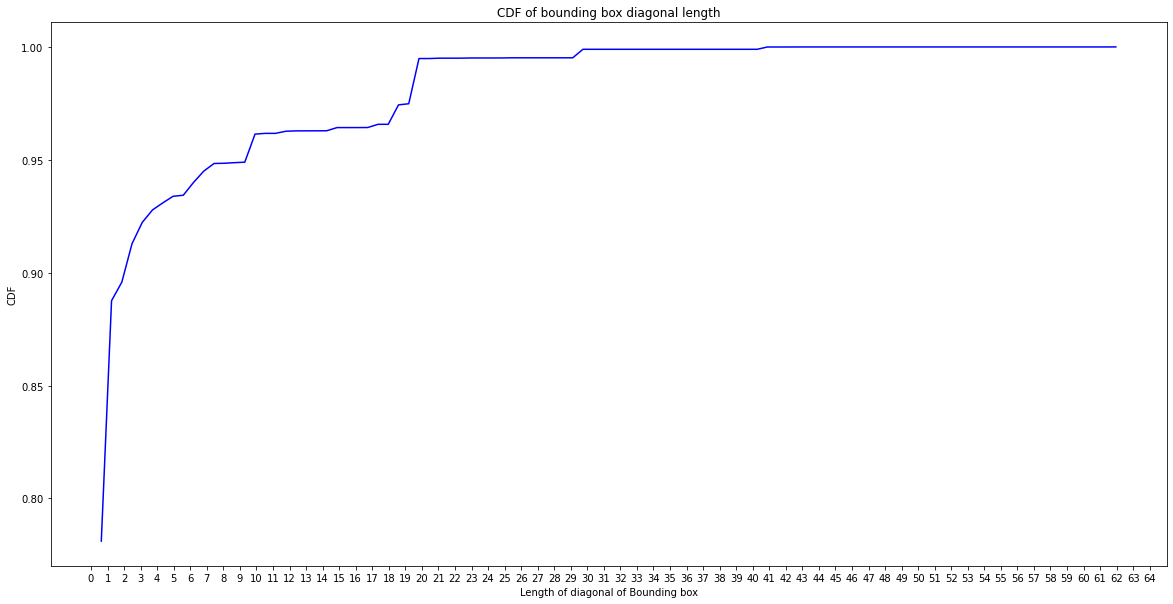

In [66]:
##QUESTION 3.3
dfg=df2['diagonal_len'].dropna()
count, bins_count = np.histogram(dfg, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(bins_count[1:], cdf, color = 'b')
ax.set_xticks(np.arange(0, 65))
ax.set_title('CDF of bounding box diagonal length') 
ax.set_xlabel('Length of diagonal of Bounding box')
ax.set_ylabel('CDF')

In [4]:
temp_list = [datetime.utcfromtimestamp(i/1000) for i in df2['timestamp'].values]
df2.insert(3, "ts", temp_list, True)

In [ ]:
df3 = df2.groupby(pd.to_datetime(df2['ts']).dt.date)['timestamp'].agg('count').reset_index()

In [ ]:
##QUESTION 2.2
df['handle'].value_counts()[:5]

In [ ]:
correspo_tweet = []
lat = []
lon = []
user = []
time = []
for i in range(len(filtered)):
    if filtered[i]['coordinates'] != None: # Some tweets don't have coordinates (not geotagged), so skipping them
        lat.append(filtered[i]['coordinates']['coordinates'][1])
        lon.append(filtered[i]['coordinates']['coordinates'][0])
        user.append(filtered[i]['user']['screen_name'])
        time.append(filtered[i]['created_at'])
        correspo_tweet.append(filtered[i]['text'])
        
# Lets save this data in a new dataframe to use for map plotting
new_df = pd.DataFrame({'tweet':correspo_tweet,'latitude':lat, 'longitude':lon, 'user':user, 'time':time})
new_df

In [ ]:
df_tm=df2[['lat','long','handle','ts']].dropna()

In [ ]:
df_tm

In [ ]:
x=[[[-0.228589, 51.477225], [-0.228589, 51.530348], [-0.149791, 51.530348], [-0.149791, 51.477225]]]
#x=[[[27.329476, 38.603424], [27.329476, 38.644525], [27.484025, 38.644525], [27.484025, 38.603424]]]

In [ ]:
x1=x[0][0][0]
y1=x[0][0][1]
x2=x[0][3][0]
y2=x[0][3][1]

In [ ]:
p1=np.array((x1,y1))
p2=np.array((x2,y2))
distance = np.linalg.norm(p1-p2)
print(distance)

In [ ]:
distance = np.linalg.norm(p1-p2)
print(distance)

In [ ]:
tweets=df2[['userid','cntry_cd']]

In [ ]:
tweets

In [ ]:
#'GB', 'ES', 'IT', 'TR'
def label_race (row):
    if row['cntry_cd']=='GB':
        return 'Great Britain'
    if row['cntry_cd']=='ES':
        return 'Spain'
    if row['cntry_cd']=='IT':
        return 'Italy'
    if row['cntry_cd']=='TR':
        return 'Turkey'
    if row['cntry_cd']=='PL':
        return 'Polska'
    if row['cntry_cd']=='IR':
        return 'Iran'    
    if row['cntry_cd']=='FR':
        return 'France'  
    if row['cntry_cd']=='CH':
        return 'China'
    if row['cntry_cd']=='IE':
        return 'Ireland' 
    if row['cntry_cd']=='NL':
        return 'Netherlands'     
    if row['cntry_cd']=='DE':
        return 'Germany'     
    if row['cntry_cd']=='IQ':
        return 'Iraq'     
    if row['cntry_cd']=='UA':
        return 'Ukraine'     
    if row['cntry_cd']=='NO':
        return 'Dominican Republic'     
    if row['cntry_cd']=='PT':
        return 'Portugal'  
    if row['cntry_cd']=='HU':
        return 'Hungary'     
    if row['cntry_cd']=='BE':
        return 'Belgium'     
    if row['cntry_cd']=='KZ':
        return 'Kazakhastan' 
    if row['cntry_cd']=='BG':
        return 'Bulgaria'     
    if row['cntry_cd']=='LI':
        return 'Liechtenstein' 
    if row['cntry_cd']=='MK':
        return 'Macedonia'      
    if row['cntry_cd']=='XK':
        return 'Kosovo'      
    if row['cntry_cd']=='AM':
        return 'Armenia'      
    if row['cntry_cd']=='SI':
        return 'Slovania'      
    if row['cntry_cd']=='RO':
        return 'Romania'  
    if row['cntry_cd']=='HR':
        return 'Croatia'      
    if row['cntry_cd']=='SY':
        return 'Syria'      
    if row['cntry_cd']=='RU':
        return 'Russia'      
    if row['cntry_cd']=='GR':
        return 'Greece'      
    if row['cntry_cd']=='DZ':
        return 'Algeria'      
    if row['cntry_cd']=='RS':
        return 'Serbia'      
    if row['cntry_cd']=='FO':
        return 'Faroe Islands'      
    if row['cntry_cd']=='CZ':
        return 'Czechia'      
    if row['cntry_cd']=='BA':
        return 'Bosnia'
    if row['cntry_cd']=='LV':
        return 'Latvia'      
    if row['cntry_cd']=='GI':
        return 'Gibraltar'      
    if row['cntry_cd']=='IS':
        return 'Iceland'      
    if row['cntry_cd']=='FI':
        return 'Finland'      
    if row['cntry_cd']=='TN':
        return 'Tunisia'      
    if row['cntry_cd']=='SE':
        return 'Sweden'      
    if row['cntry_cd']=='LU':
        return 'Luxembourg'      
    if row['cntry_cd']=='MT':
        return 'Malta'      
    if row['cntry_cd']=='AT':
        return 'Austria'      
    if row['cntry_cd']=='DK':
        return 'denmark'      
    if row['cntry_cd']=='IN':
        return 'India'      
    if row['cntry_cd']=='BY':
        return 'Belarus'      
    if row['cntry_cd']=='CY':
        return 'Cyprus'      
    if row['cntry_cd']=='GE':
        return 'Georgia'  
    if row['cntry_cd']=='ME':
        return 'Montenergo'      
    if row['cntry_cd']=='MA':
        return 'Morocco'      
    if row['cntry_cd']=='SK':
        return 'Slovakia'      
    if row['cntry_cd']=='UZ':
        return 'Uzbekistan'      
    if row['cntry_cd']=='MC':
        return 'Monaco'      
    if row['cntry_cd']=='AZ':
        return 'Azerbaijan'      
    if row['cntry_cd']=='AF':
        return 'Afghanistan'      
    if row['cntry_cd']=='PK':
        return 'Pakistan'      
    if row['cntry_cd']=='AL':
        return 'Albania'      
    if row['cntry_cd']=='TM':
        return 'Turkmenistan'
    if row['cntry_cd']=='AD':
        return 'Andorra'      
    if row['cntry_cd']=='EE':
        return 'Estonia'      
    if row['cntry_cd']=='VA':
        return 'Vatican City'      
    if row['cntry_cd']=='LT':
        return 'Lithuania'      
    if row['cntry_cd']=='JE':
        return 'Jersey'      
    if row['cntry_cd']=='GL':
        return 'Greenland'      
    if row['cntry_cd']=='TJ':
        return 'Tajikistan'      
    if row['cntry_cd']=='MD':
        return 'Moldova'      
    if row['cntry_cd']=='GG':
        return 'Guernsey'      
    if row['cntry_cd']=='IM':
        return 'Isle of Man'      
    if row['cntry_cd']=='SM':
        return 'San Marino'      
    if row['cntry_cd']=='AX':
        return 'Aland Island'      
    return np.nan

df2['country'] = df2.apply(lambda row: label_race(row), axis=1)



##QUESTION 2.4

country_code = df2[['country', 'cntry_cd']].drop_duplicates().dropna()

country_mention = ['GB', 'ES', 'IT', 'TR']

df_user_country = df2[['userid', 'cntry_cd']]
df_user_country = df_user_country.groupby(['userid', 'cntry_cd']).size()
df_user_country = df_user_country.sort_values(ascending=False)
df_user_country = df_user_country.reset_index(name='count')
df_user_country = df_user_country.drop_duplicates(subset='userid', keep='first').drop(columns = 'count')

df_mention_count = pd.DataFrame(columns=country_mention, index=country_mention)

for c in country_mention: 
    df_tweets = df2.loc[tweets['cntry_cd'] == c]
    mentions_id = [j for i in df_tweets['mention'] for j in eval(i) if len(eval(i)) > 0]
    df_mentions_id = pd.DataFrame({'user': mentions_id})
    df_mentions_country = df_mentions_id.merge(df_user_country,how='left', on='user').dropna()

    for i in range(len(country_mention)): 
        df_mention_count.at[c, country_mention[i]] = len(
            df_mentions_country.loc[df_mentions_country['cntry_cd'] ==country_mention[i]])

In [ ]:
df2

In [ ]:
#print(df['Courses'].unique())
print(df2['cntry_cd'].unique())

In [ ]:
#tweets=tweets.dropna()
tweets

In [ ]:
country_code = df2[['country', 'cntry_cd']].drop_duplicates().dropna()

country_mention = ['GB', 'ES', 'IT', 'TR']

df_user_country = df2[['userid', 'cntry_cd']]
df_user_country = df_user_country.groupby(['userid', 'cntry_cd']).size()
df_user_country = df_user_country.sort_values(ascending=False)
df_user_country = df_user_country.reset_index(name='count')
df_user_country = df_user_country.drop_duplicates(subset='userid', keep='first').drop(columns = 'count')

df_mention_count = pd.DataFrame(columns=country_mention, index=country_mention)

for c in country_mention: 
    df_tweets = df2.loc[tweets['cntry_cd'] == c]
    mentions_id = [j for i in df_tweets['mention'] for j in eval(i) if len(eval(i)) > 0]
    df_mentions_id = pd.DataFrame({'user': mentions_id})
    df_mentions_country = df_mentions_id.merge(df_user_country,how='left', on='user').dropna()

    for i in range(len(country_mention)): 
        df_mention_count.at[c, country_mention[i]] = len(df_mentions_country.loc[df_mentions_country['cntry_cd'] ==country_mention[i]])

In [42]:
##QUESTION 3.1

import folium.plugins as plugins
import folium
correspo_tweet = []
lat = []
lon = []
user = []
time = []
for i in range(len(df2)):
    if df2['lat'].iloc[i]>0 or df2['lat'].iloc[i]<0 or df2['lat'].iloc[i]==0: # Some tweets don't have coordinates (not geotagged), so skipping them
        lat.append(df2['lat'].iloc[i])
        lon.append(df2['long'].iloc[i])
        user.append(df2['userid'].iloc[i])
        time.append(df2['ts'].iloc[i])
        correspo_tweet.append(df2['texts'].iloc[i].replace("'","").replace('"',''))


new_df = pd.DataFrame({'tweet':correspo_tweet,'latitude':lat, 'longitude':lon, 'user':user, 'time':time})
new_df=new_df.dropna()


pop = ["{} From: @{} at {}".format(t,u,ti) for t,u,ti in zip(correspo_tweet,user,time)]
# points = [list(i) for i in zip(lat,lon,pop)]

# Give info about folium javascript callbacks
callback = """\
function (row) {
    var marker;
    marker = L.circle(new L.LatLng(row[0], row[1]), {color:'red'});
    return marker;
};
"""

points = [list(i) for i in zip(lat,lon,str(correspo_tweet))]
dummy2 = pd.DataFrame(points, columns=['lat', 'lng','pop'])
dmap = folium.Map(zoom_start = 7)
plugins.FastMarkerCluster(points, callback=callback).add_to(dmap)


for i in range(0,len(points)):
    iframe = folium.IFrame(points[i][2],width=300,height=100)
    popup = folium.Popup(iframe,max_width=300)
    marker = folium.Marker([points[i][0],points[i][1]],popup=popup).add_to(dmap)

dmap.save("mymap.html")    
dmap

In [40]:
dummy2

,lat,lng,pop
0,52.481388,13.435000,bau weia! eens! b?m
1,44.497500,8.987778,"b01:00\nTemp. 15,0?C App. 15,9?C\nUmid. 95% \n..."
2,50.450861,30.524574,"b????? ?????? ???? ?? ????????? ?????, ??????...."
3,49.841809,24.031343,b??? ???\n?????????!
4,41.545639,1.893817,b?s la una en punt de la nit
...,...,...,...
701956,47.471900,19.050300,bBajnokok ha tal?lkoznak... @ofzeoh turn?ind?t...
701957,50.263503,19.024350,bThe?Silesian Insurgents Monument?(Polish:?Pom...
701958,49.983300,82.616700,b?????? ??? ???????????? ???? @ ?skemen https:...
701959,47.496655,19.056978,b?My favorite thing is to go where I?ve never ...


In [16]:
new_df

,tweet,latitude,longitude,user,time
0,b'au weia! eens! b?m',52.481388,13.435000,1092190045,2022-05-31 23:00:00.165
1,"b'01:00\nTemp. 15,0?C App. 15,9?C\nUmid. 95% \...",44.497500,8.987778,2858863684,2022-05-31 23:00:01.130
2,"b'????? ?????? ???? ?? ????????? ?????, ??????...",50.450861,30.524574,95102918,2022-05-31 23:00:01.900
3,b'??? ???\n?????????!',49.841809,24.031343,95722016,2022-05-31 23:00:01.915
4,b'?s la una en punt de la nit',41.545639,1.893817,1384110594,2022-05-31 23:00:02.187
...,...,...,...,...,...
701956,b'Bajnokok ha tal?lkoznak... @ofzeoh turn?ind?...,47.471900,19.050300,41115182,2022-06-30 22:59:09.828
701957,"b""The?Silesian Insurgents' Monument?(Polish:?P...",50.263503,19.024350,2578133605,2022-06-30 22:59:46.467
701958,b'?????? ??? ???????????? ???? @ ?skemen https...,49.983300,82.616700,1542182548649959425,2022-06-30 22:59:55.287
701959,b'?My favorite thing is to go where I?ve never...,47.496655,19.056978,378041468,2022-06-30 22:59:55.308


In [43]:
dmap

In [48]:
dfg=df2['diagonal_len'].dropna()

In [54]:
dfg.iloc[:]

0        0.078798
2        0.154549
3        0.103171
4        0.160032
5        0.091353
           ...   
19101    0.746237
19102    0.279633
19103    0.418476
19104    0.173738
19105    0.319565
Name: diagonal_len, Length: 15026765, dtype: float64

In [73]:
df2.query("userid==31567867")['texts'].iloc[0]

"b'A male cat was lost on 17/05/2022 in The Local Area, #Charleville https://t.co/L1Q5TU8NFZ #lpie https://t.co/5UbKyh3dAK'"

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english') 
stopwords_fr = stopwords.words('french')

country = 'GB' # United Kingdom
country = 'IE' # Ireland
country = 'FR' # France 

df_country = df2.loc[df2['cntry_cd'] == country].copy()
df_country['created_at_hour'] = pd.to_datetime(df_country['ts'], format='%H:%M:%S').dt.hour

df_country_summary = pd.pivot_table(df_country, values=['texts'],index=['created_at_date'], columns=['created_at_hour'],aggfunc='count')

unusual_day = df_country_summary.max(axis=1).idxmax()

df_country_summary = df_country_summary.fillna(0)
vals = df_country_summary.values
rows = df_country_summary.index
cols = df_country_summary.columns

fig, ax = plt.subplots(figsize = (15, 10))
normal = plt.Normalize(0, vals.max()+1)
colours = plt.cm.RdYlGn(normal(vals))

In [85]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harshita\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
del tweets_by_country_UK

Text(0, 0.5, 'Number of tweets')

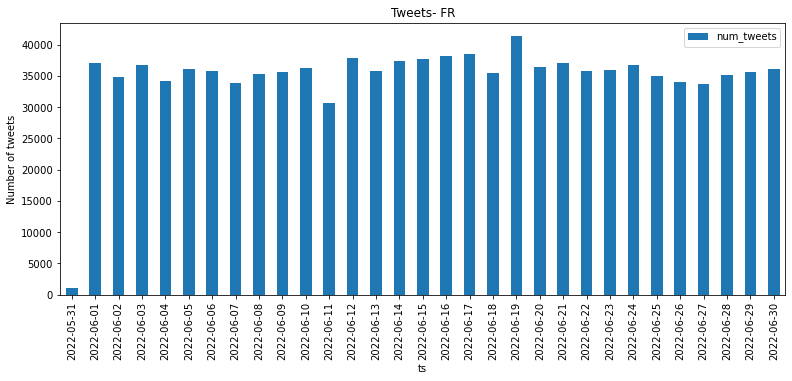

In [56]:
tweets_by_country_FR = df2[df2['cntry_cd'] == 'FR']
tweets_by_country_FR = tweets_by_country_FR.groupby([tweets_by_country_FR['ts'].dt.date]).count()[['tid']]
tweets_by_country_FR = tweets_by_country_FR.reset_index()
tweets_by_country_FR.rename(columns = {'tid':'num_tweets'}, inplace = True)
tweets_by_country_FR = tweets_by_country_FR.set_index('ts')
ax = tweets_by_country_FR.plot(kind='bar',figsize = (13,5))
ax.set_title("Tweets- FR")
ax.set_ylabel("Number of tweets")

Text(0, 0.5, 'Number of tweets')

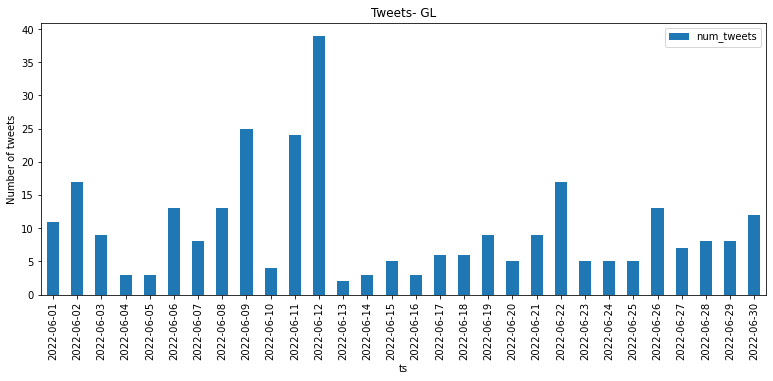

In [25]:
tweets_by_country_GL = df2[df2['cntry_cd'] == 'GL']
tweets_by_country_GL = tweets_by_country_GL.groupby([tweets_by_country_GL['ts'].dt.date]).count()[['tid']]
tweets_by_country_GL = tweets_by_country_GL.reset_index()
tweets_by_country_GL.rename(columns = {'tid':'num_tweets'}, inplace = True)
tweets_by_country_GL = tweets_by_country_GL.set_index('ts')
ax = tweets_by_country_GL.plot(kind='bar',figsize = (13,5))
ax.set_title("Tweets- GL")
ax.set_ylabel("Number of tweets")

Text(0, 0.5, 'Number of tweets')

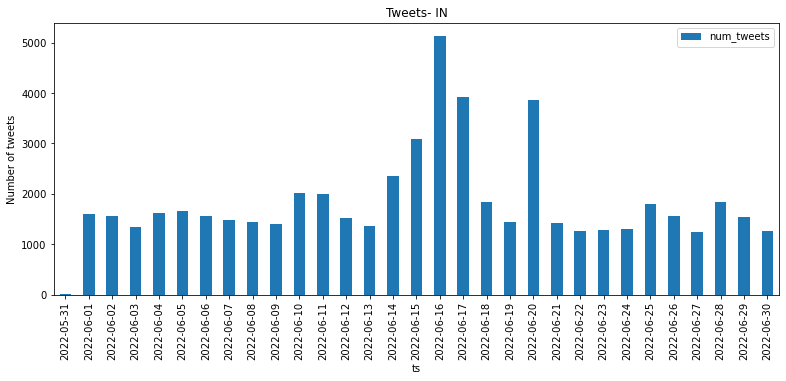

In [26]:
tweets_by_country_IN = df2[df2['cntry_cd'] == 'IN']
tweets_by_country_IN = tweets_by_country_IN.groupby([tweets_by_country_IN['ts'].dt.date]).count()[['tid']]
tweets_by_country_IN = tweets_by_country_IN.reset_index()
tweets_by_country_IN.rename(columns = {'tid':'num_tweets'}, inplace = True)
tweets_by_country_IN = tweets_by_country_IN.set_index('ts')
ax = tweets_by_country_IN.plot(kind='bar',figsize = (13,5))
ax.set_title("Tweets- IN")
ax.set_ylabel("Number of tweets")

In [57]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/FR/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/FR/"

#files[1:]
k=[]
for f in files:
    m=directory+f
    k.append(m)

df_FR = pd.concat(map(pd.read_csv, k))
len(df)
df_FR=df_FR.drop_duplicates()
df_FR

temp_list = [datetime.utcfromtimestamp(i/1000) for i in df_FR['timestamp'].values]
df_FR.insert(3, "ts", temp_list, True)

df_FR=df_FR[df_FR['cntry_cd']=="FR"]

In [48]:
df_FR

,tid,lang,timestamp,ts,long,lat,userid,handle,mention,m_han,cntry_cd,diagonal_len,texts,tags
5,1539745048207790082,und,1655938801229,2022-06-22 23:00:01.229,NaN,NaN,1484977221123067908,selenaselly2002,1280260872997416965/,#OnlyMurdersHulu,FR,0.245804,b'@OnlyMurdersHulu Jan',b''
11,1539745052108406784,en,1655938802159,2022-06-22 23:00:02.159,NaN,NaN,1178504995,rbpi_bot,NaN,NaN,FR,0.245804,b'I started 10 days 4 hours and 32 minutes ago...,b'#RaspberryPi'
19,1539745054797037574,zxx,1655938802800,2022-06-22 23:00:02.800,NaN,NaN,1495826357812707336,AbderrahimElMi7,NaN,NaN,FR,0.038128,b'https://t.co/JT197tuvvn',b''
77,1539745104566439936,en,1655938814666,2022-06-22 23:00:14.666,NaN,NaN,1392872799794913280,gin_nnnn_,1504716199837396995/,#LonelyPopNFT,FR,0.245804,b'Wooohoooo. Isn?t mine lonelypop just Lovely?...,b'#LonelyTogether'
79,1539745105179181056,fr,1655938814812,2022-06-22 23:00:14.812,NaN,NaN,2306547516,Los_Santos_24,780132002913714181/,#iamgrrace,FR,0.040652,b'@iamgrrace Mouahahahaha un comportement d?ho...,b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18543,1540107368230518785,en,1656025185054,2022-06-23 22:59:45.054,NaN,NaN,1490044592607145986,barbarous94,1493690098939940866/,#wiwietletaxii,FR,0.067440,b'@wiwietletaxii LETS GOOOO??',b''
18563,1540107389646639107,fr,1656025190160,2022-06-23 22:59:50.160,NaN,NaN,1307278716167430144,che__dz,1409296927666094081/,#Ray12wth,FR,0.039188,b'@Ray12wth Vraiment heureusement t?es l? pour...,b''
18584,1540107406587432967,it,1656025194199,2022-06-23 22:59:54.199,NaN,NaN,560384497,Miky77Coni,398100478/,#BaliaLuigi,FR,0.099257,b'@BaliaLuigi Mi pare ovvio che ti sia bevuto ...,b''
18591,1540107413893808129,es,1656025195941,2022-06-23 22:59:55.941,NaN,NaN,230833674,nayluune,NaN,NaN,FR,0.068997,b'Estamos yendo en una furgoneta to gucci del ...,b''


In [59]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/GL/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/GL/"

k=[]
for f in files:
    m=directory+f
    k.append(m)

df_GL = pd.concat(map(pd.read_csv, k))
len(df)
df_GL=df_GL.drop_duplicates()
df_GL

temp_list = [datetime.utcfromtimestamp(i/1000) for i in df_GL['timestamp'].values]
df_GL.insert(3, "ts", temp_list, True)

df_GL=df_GL[df_GL['cntry_cd']=="GL"]

In [60]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/IN/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/IN/"

k=[]
for f in files:
    m=directory+f
    k.append(m)

df_IN = pd.concat(map(pd.read_csv, k))
len(df)
df_IN=df_IN.drop_duplicates()
df_IN

temp_list = [datetime.utcfromtimestamp(i/1000) for i in df_IN['timestamp'].values]
df_IN.insert(3, "ts", temp_list, True)

df_IN=df_IN[df_IN['cntry_cd']=="IN"]

In [36]:
df_IN

,tid,lang,timestamp,ts,long,lat,userid,handle,mention,m_han,cntry_cd,diagonal_len,texts,tags
0,1537208328341925888,in,1655334000083,2022-06-15 23:00:00.083,NaN,NaN,1371135095378227202,SAMIRAMENDEZGO1,2491764466/,#wendycruz72,ES,0.370995,b'@wendycruz72 merhaba\n\n#Ak?nAk?n?z?\n#kader...,b'#Ak?nAk?n?z?#kaderiminOyunu'
1,1537208328648110087,en,1655334000156,2022-06-15 23:00:00.156,13.435000,52.481388,1092190045,rh_neukoelln,NaN,NaN,NaN,NaN,b'frier',b''
2,1537208329952542726,pt,1655334000467,2022-06-15 23:00:00.467,NaN,NaN,809893446110642176,rubenjames_23,NaN,NaN,PT,0.133464,b'Eu n?o considero isto normal mas tenho que a...,b''
3,1537208331290435584,it,1655334000786,2022-06-15 23:00:00.786,8.987778,44.497500,2858863684,sulsitodisimone,NaN,NaN,IT,0.091353,"b'01:00\nTemp. 19,3?C App. 21,5?C\nUmid. 89% \...",b''
4,1537208332561309696,fr,1655334001089,2022-06-15 23:00:01.089,NaN,NaN,1107247382,Stef_SD,NaN,NaN,FR,0.245804,b'Bah oui du coup vu que maintenant c?est Edge',b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17972,1537570710532628480,es,1655420398730,2022-06-16 22:59:58.730,NaN,NaN,406297841,LluisGa07,236790645/,#mireia__p,ES,0.177501,b'@mireia__p Te bloqueo prima',b''
17973,1537570710759014401,tr,1655420398784,2022-06-16 22:59:58.784,NaN,NaN,1192156645750714368,cutedady47,NaN,NaN,TR,0.179627,"b'""Gitmez"",dedi?in herkesi u?urlamaya al??..?'",b''
17974,1537570711740497920,ar,1655420399018,2022-06-16 22:59:59.018,NaN,NaN,933835191495348224,elsurri6,NaN,NaN,SY,6.788483,b'??????? ??? ????? ??? ??',b''
17975,1537570712763908096,tr,1655420399262,2022-06-16 22:59:59.262,NaN,NaN,1044457784,_Mepos,NaN,NaN,TR,0.107652,b'?ok s?k?ld?m ve yoruldum kafam?n i?ini s?k?p...,b''


In [37]:
def hashtags(series_values):
    '''
    Generates a list of hashtags from series of hashtag data of tweets
    series_values: pandas series from dataframe
    hashtags_final: python list of hashtags
    '''
    hashtags = list(series_values)
    hashtags_final = []
    for i in hashtags:
        if type(i) == list:
            hashtags_final.extend(i)
    return hashtags_final

In [38]:
# Creating a list of hashtags for 17th march ireland tweets
hashtags_17 = hashtags(df_AF['tags'].values)

In [51]:
df_FR['texts'].values

array(["b'@OnlyMurdersHulu Jan'",
       "b'I started 10 days 4 hours and 32 minutes ago. Let us be precise, please! #RaspberryPi'",
       "b'https://t.co/JT197tuvvn'", ...,
       "b'@BaliaLuigi Mi pare ovvio che ti sia bevuto il cervello'",
       "b'Estamos yendo en una furgoneta to gucci del Hellfest y a mitad de camino en medio de la nada nos hemos encontrado a? https://t.co/AvUXadQij9'",
       "b'@W9Twkz Bonjour https://t.co/XnWqcO4Zch'"], dtype=object)

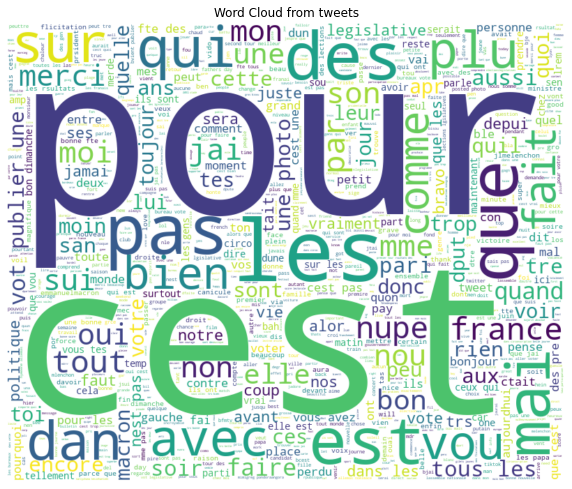

In [61]:
## Creating word cloud of tweets for France ## 
wc_tweets_FR = list(df_FR['texts'].values)
make_wordcloud(data_list=wc_tweets_FR,mask_image_path = 'twitter.png',title='Word Cloud from tweets',processed=False,max_words=2000)

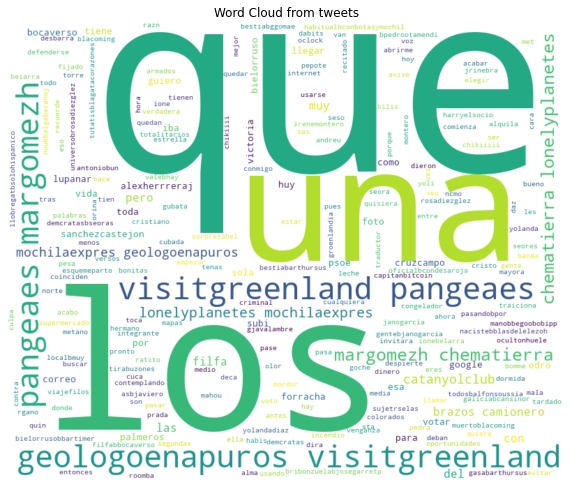

In [62]:
## Creating word cloud of tweets for Greenland ## 
wc_tweets_GL = list(df_GL['texts'].values)
make_wordcloud(data_list=wc_tweets_GL,mask_image_path = 'twitter.png',title='Word Cloud from tweets',processed=False,max_words=2000)

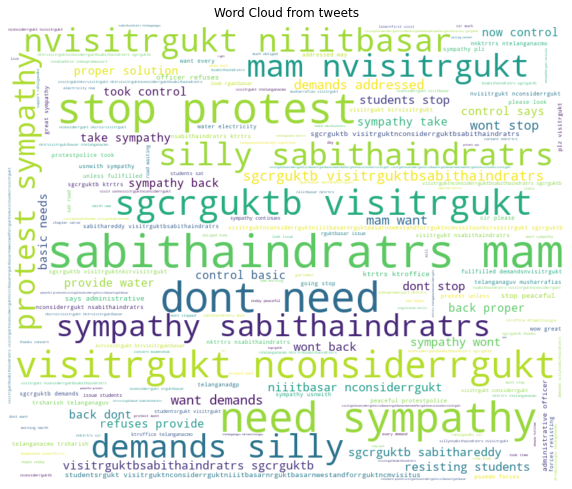

In [63]:
## Creating word cloud of tweets for India ## 
wc_tweets_IN = list(df_IN['texts'].values)
make_wordcloud(data_list=wc_tweets_IN,mask_image_path = 'twitter.png',title='Word Cloud from tweets',processed=False,max_words=2000)

In [ ]:
## Creating word cloud of tweets for France ## 
wc_tweets_FR = list(df_FR['tags'].values)
make_wordcloud(data_list=wc_tweets_FR,mask_image_path = 'twitter.png',title='Word Cloud from tweets',processed=False,max_words=2000)

In [ ]:
##QUESTION 2.4
import ast

ref_dict = {}
dict1 = {}

for idx, row in df2.iterrows():
    if row['userid'] not in ref_dict:
        ref_dict[ row['userid'] ] = row['cntry_cd']

empty_mention = '[]'
df2 = df2[df2.mention != empty_mention]
        
for idx, row in df.iterrows():
    if row['cntry_cd'] not in dict1:
        dict1[ row['cntry_cd'] ] = []
        
    mentions = ast.literal_eval(row['mention'])
    for mention in mentions:
        dict1[ row['cntry_cd'] ].append(mention['tid'])

for k, v in dict1.items():
    for i in range(len(v)):
        if int(v[i]) in ref_dict:
            dict1[k][i] = ref_dict[int(v[i])]

countries = {
    'DE': 'Germany',
    'BE': 'Belgium',
    'ES': 'Spain',
    'TR': 'Turkey'
}

mentions = {}

for i in countries.keys():
    if i not in mentions:
        mentions[i] = {}
        
    for j in countries.keys():
        mentions[i][j] = dict1[i].count(j)
        
print(mentions)

In [66]:
df2

,tid,lang,timestamp,ts,long,lat,userid,handle,mention,m_han,cntry_cd,diagonal_len,texts,tags
0,1531772510450208769,und,1654038000105,2022-05-31 23:00:00.105,NaN,NaN,127625257,valerievalentin,NaN,NaN,GB,0.078798,b'https://t.co/B3K8DCQpXg',b''
1,1531772510701748225,de,1654038000165,2022-05-31 23:00:00.165,13.435,52.481388,1092190045,rh_neukoelln,NaN,NaN,NaN,NaN,b'au weia! eens! b?m',b''
2,1531772513306525696,tr,1654038000786,2022-05-31 23:00:00.786,NaN,NaN,28993079,mosb45,1473087969829568516/,#nurse_hmsre,TR,0.154549,b'@nurse_hmsre Hay?r akepe yi aya g?nder mek',b''
3,1531772513809842176,it,1654038000906,2022-05-31 23:00:00.906,NaN,NaN,867134762,dangobb,4185660388/,#gigi52335676,IT,0.103171,b'@gigi52335676 Ci riprenderemo le colonie e a...,b''
4,1531772514262831104,es,1654038001014,2022-05-31 23:00:01.014,NaN,NaN,635624391,MrRichi94,902638832675430400/,#rompelavabos,ES,0.160032,"b'@rompelavabos No me consta, eso qu? es? ??? ...",b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19101,1542644142123220993,tr,1656629999081,2022-06-30 22:59:59.081,NaN,NaN,275768492,hidayet18,1531416100512190465/,#Peri_Evrim,TR,0.746237,b'@Peri_Evrim Affferim sana bee ?? https://t.c...,b''
19102,1542644142613880832,en,1656629999198,2022-06-30 22:59:59.198,NaN,NaN,787066567892828160,realmichcollins,NaN,NaN,IE,0.279633,b'SUNDAY Reset Vlog https://t.co/j2d2Ip44g1 ht...,b''
19103,1542644143679328256,pl,1656629999452,2022-06-30 22:59:59.452,NaN,NaN,754095617941594112,Pan_Dubon,943822446796435456/,#trockizm98,PL,0.418476,b'@trockizm98 Ot?? nie. Floh de cologne nie zn...,b''
19104,1542644144945987584,es,1656629999754,2022-06-30 22:59:59.754,NaN,NaN,155554329,luciamol99,625802146/,#clawdialopez,ES,0.173738,"b'@clawdialopez Mi ni?a, enseguida juntisssss ...",b''


In [ ]:
def getcountry1(data):
    if data:
        if data['country']:
            return data['country']
        else:
            return np.nan
    else:
        return np.nan

def getplc1(data):
    if data:
        if data['name']:
            return data['name']
        else:
            return np.nan
    else:
        return np.nan
        
def getbb(data):
    if data:
        if data['bounding_box'] and data['bounding_box']['coordinates']:
            return data['place']['bounding_box']['coordinates']
        else:
            return np.nan
    else:
        return np.nan        

def getment1(data):
    if data:
        if data['user_mentions']:
            data['user_mentions'] = data['entities']['user_mentions']
            data['user_mentions_id'] = []
            for j in range(len(data['user_mentions'])):
                data['user_mentions_id'].append(data['user_mentions'][j]['id_str'])
            return ['user_mentions']
        else:
            return np.nan
    else:
        return np.nan

#z=r'C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/Rhy/TwitterJune2022/'
ids=[]
count=0
files = os.listdir(r'C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/Rhy/TwitterJune2022/')
for k in files:
    direc=k+".json"
    with open(path+k+"/"+"geoEurope"+"/"+direc) as files:
        for y in files:
            d=json.loads(y)
            if "id" in d:
                print("hi")
                ids.append(d["id_str"])
                long , lat = getcoordinates(d['coordinates'])
                #coord =zip(long,lat)
                cnt=getcountry1(d['place'])
                plc=getplc1(d['place'])
                #bb=getbb(d['place'])
                um=getment1(d['entities'])


#             mention, m_han= getmention(d['entities'])
#             tags = gethashtags(d['entities'])
#             diagonal_len = getdiagonal(d['place'])
                cntry_cd = getcountry(d['place'])
            #text1 = gettext(d['text'])
    #                         pmin , pmax : bbdiagonal(d['place']['bounding_box']['coordinates'])
                data={
                    "username":d['user']['name'],
                    "user":d['user']['id_str'],
                    #"coordinates" : coord,
                    "place" : cnt, #write func
                    "country_code" : cntry_cd,
                    "place_name" : plc, #write func
                    #"bounding_box" : bb, #write func
                    "user_mentions_id" : um #write code                 
                    }

            csv_columns = ['username','user','place','country_code','place_name','user_mentions_id']
                                #csv_columns = ['tid','lang','times','long','lat','userid','handel','mention','m_han','tags','pmin','pmax']
            csv_file = k+".csv"
                                #print(csv_file)
            try:
                if count==0:
                    count=1
                    with open(csv_file, 'w') as csvfile:
                        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                        writer.writeheader()
                        writer.writerow(data)
                        csvfile.close()
                else:
                    count+=1
                    with open(csv_file, 'a') as csvfile:
                        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                        writer.writerow(data)
                        csvfile.close()
            except IOError:
                print("I/O error")


end = t.time()
print("time ended in sec : ", end - start)
print("time ended in mins : ",((end - start)/60))
print("time ended in hrs : ",((end - start)/3600))
print("Time ended for making a CSV")
print(type(d),len(d))

In [ ]:
files = os.listdir(r'C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/Rhy/TwitterJune2022/')
path=r'C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/Rhy/TwitterJune2022/'
for k in files:
    direc=k+".json"
    with open(path+k+"/"+"geoEurope"+"/"+direc) as files:
        for y in files:
            d = json.loads(y)
            if "id" in d:
                print("hello")
            
            
            
            
#             with open('geoEurope_2022060100.json') as f:
#     for y in f:
#         data = json.loads(y)

In [ ]:
data

In [99]:
f = open('geoEurope_2022060100.json')
#data = json.load(f)

In [ ]:
#with open('geoEurope_2022060100.json') as f:
dg=pd.read_json('geoEurope_2022060100.json')
#     for y in f:
#         data = json.loads(y)
#         dg=pd.read_json(data)

In [108]:
def getcoordinates(data):
    if data and len(data["coordinates"]) == 2:
        return data["coordinates"][0], data["coordinates"][1]
    return np.nan,np.nan 

In [112]:
def getcountry(data):
    if data:
        if data["country_code"]:
            if len(data["country_code"])>0:
                return data["country_code"]
    return np.nan

In [ ]:
import pandas as pd
dg=pd.read_json(r'C:\Users\Harshita\Exeter\Introduction to DS\Coursework\11\Working directory\geoEurope_2022060100.json')

In [133]:
u=df[['tid','userid','lang','timestamp','long','lat','handle','mention','cntry_cd','texts']]

In [134]:
u

,tid,userid,lang,timestamp,long,lat,handle,mention,cntry_cd,texts
0,1531772510450208769,127625257,und,1654038000105,NaN,NaN,valerievalentin,NaN,GB,b'https://t.co/B3K8DCQpXg'
1,1531772510701748225,1092190045,de,1654038000165,13.435,52.481388,rh_neukoelln,NaN,NaN,b'au weia! eens! b?m'
2,1531772513306525696,28993079,tr,1654038000786,NaN,NaN,mosb45,1473087969829568516/,TR,b'@nurse_hmsre Hay?r akepe yi aya g?nder mek'
3,1531772513809842176,867134762,it,1654038000906,NaN,NaN,dangobb,4185660388/,IT,b'@gigi52335676 Ci riprenderemo le colonie e a...
4,1531772514262831104,635624391,es,1654038001014,NaN,NaN,MrRichi94,902638832675430400/,ES,"b'@rompelavabos No me consta, eso qu? es? ??? ..."
...,...,...,...,...,...,...,...,...,...,...
19101,1542644142123220993,275768492,tr,1656629999081,NaN,NaN,hidayet18,1531416100512190465/,TR,b'@Peri_Evrim Affferim sana bee ?? https://t.c...
19102,1542644142613880832,787066567892828160,en,1656629999198,NaN,NaN,realmichcollins,NaN,IE,b'SUNDAY Reset Vlog https://t.co/j2d2Ip44g1 ht...
19103,1542644143679328256,754095617941594112,pl,1656629999452,NaN,NaN,Pan_Dubon,943822446796435456/,PL,b'@trockizm98 Ot?? nie. Floh de cologne nie zn...
19104,1542644144945987584,155554329,es,1656629999754,NaN,NaN,luciamol99,625802146/,ES,"b'@clawdialopez Mi ni?a, enseguida juntisssss ..."


In [ ]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/csv/"

def taskOne(files):
    
    tweets_day = []
    lang_count = Counter()
    t_hour = []
   
    for f in files:    
        df = pd.read_csv(directory+f)
        # Storing tweets for each day - Task 1.2, 1.3, 1.5
        tweets_day.append(len(df))
        
        # Saving tweet count per language - Task 1.4
        for k, v in df.groupby(by='lang').groups.items():
            lang_count[k] += len(v)
        
        # Saving tweet count for every hour - Task 1.6
        vfunc = np.vectorize(lambda x: dt.fromtimestamp(x/1000).hour )
        a, c = np.unique(vfunc(df["timestamp"]), return_counts=True)
        t_hour.append(c.tolist())
        
    return np.array(tweets_day), lang_count, t_hour


#files = sorted(files)

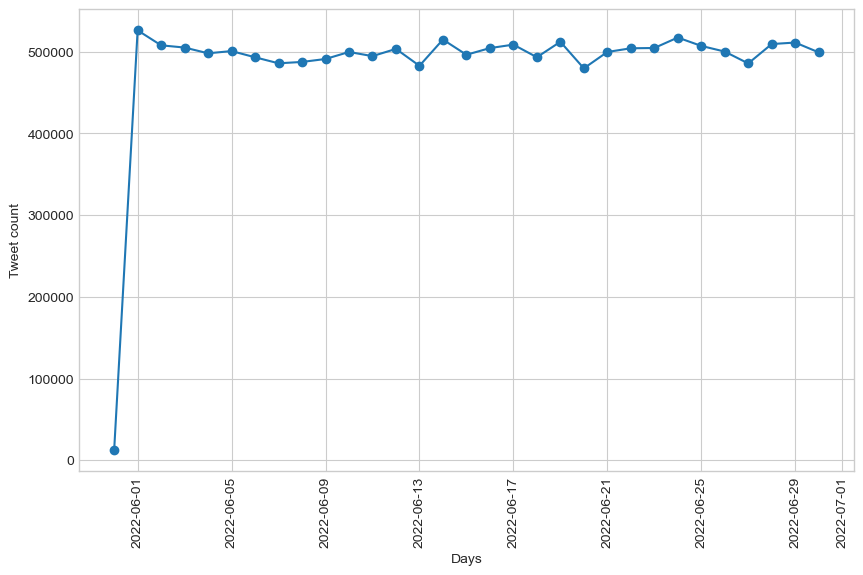

In [140]:
rcParams['figure.figsize']=10,6
plt.scatter(df3.ts, df3.timestamp)
plt.plot(df3.ts, df3.timestamp)
plt.xticks(rotation = 90)
plt.xlabel("Days")
plt.ylabel("Tweet count")
plt.show()

Text(0.5, 1.0, 'Number of tweets on each day of June')

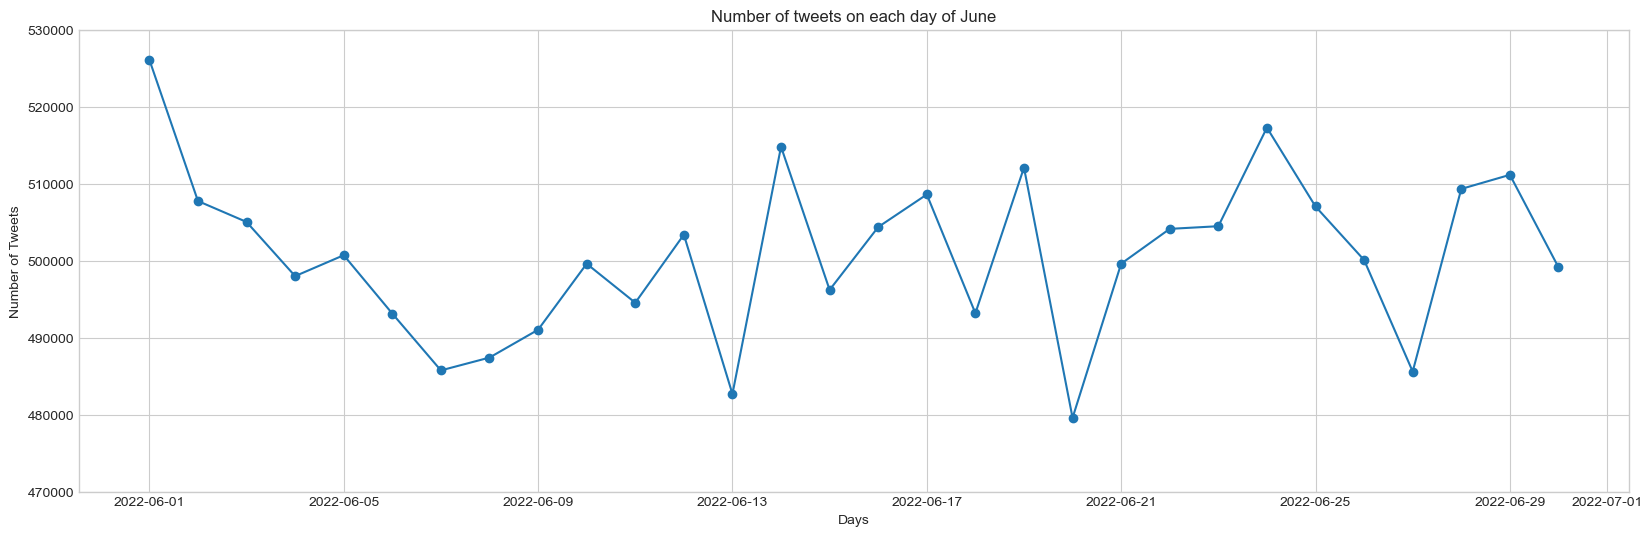

In [154]:
plt.figure(figsize=(20,6))
plt.grid(True)
plt.scatter(list(df3.ts[1:]),list(df3.timestamp[1:]))
plt.plot(list(df3.ts[1:]),list(df3.timestamp[1:]))
plt.xlabel('Days')
plt.ylabel('Number of Tweets')
plt.ylim(470000,530000)
plt.title("Number of tweets on each day of June")

In [ ]:
df3.ts[1:]

C:\Users\Harshita\AppData\Local\Temp\ipykernel_18512\1417771948.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i/1000) for i in ax.get_xticks().tolist()])


[Text(0.0, 0, '0'),
 Text(1.0, 0, '0'),
 Text(2.0, 0, '0'),
 Text(3.0, 0, '0'),
 Text(4.0, 0, '0'),
 Text(5.0, 0, '0'),
 Text(6.0, 0, '0'),
 Text(7.0, 0, '0'),
 Text(8.0, 0, '0'),
 Text(9.0, 0, '0'),
 Text(10.0, 0, '0')]

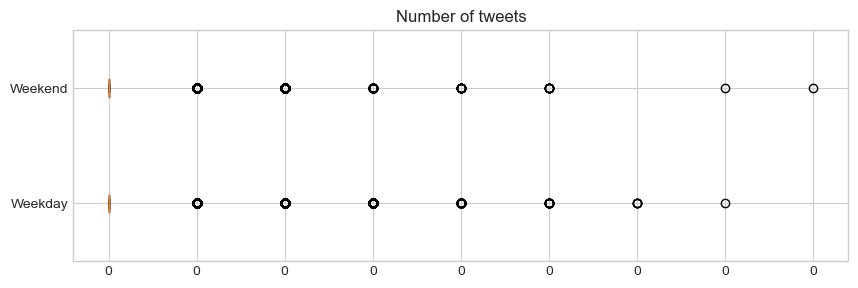

In [161]:
fig, ax = plt.subplots(figsize = (10,3))
ax.boxplot([df_dates[df_dates['is_weekend'] == False]['days_count'], 
            df_dates[df_dates['is_weekend'] == True]['days_count']], 
            vert = False, labels = ['Weekday', 'Weekend'])
ax.set_title("Number of tweets")
ax.set_xticklabels([int(i/1000) for i in ax.get_xticks().tolist()])

In [159]:
weekends = ['Saturday', 'Sunday']
df2['created_at_time'] = pd.to_datetime(df2['ts']).dt.time
df2['day_of_week'] = pd.to_datetime(df2['ts']).dt.day_name()
df2['is_weekend'] = df2['day_of_week'].isin(weekends)

df_dates = df2[['ts', 'is_weekend']]
df_dates = df_dates.groupby(['ts','is_weekend'])['ts'].count().reset_index(name = 'days_count')

In [ ]:
df_users = pd.DataFrame() # Initialise a new dataframe for user details

screen_name = [] 
twt = []
verified = []
time = []
timestamp = []
description = []
friends = []

for i in df2:
    screen_name.append(i['handle'])
    twt.append(i['texts'])
    verified.append(i['user']['verified'])
    time.append(i['created_at'])
    timestamp.append(i['timestamp_ms'])
    description.append(i['user']['description'])
    friends.append(i['user']['friends_count'])
    
df_users['user'] = screen_name
df_users['tweet'] = twt
df_users['verified'] = verified
df_users['time'] = pd.to_datetime(time)
df_users['friends'] = friends
df_users['description'] = description

In [168]:
##QUESTION 2.2
top_5users=df2['handle'].value_counts()[:5]
# for i in top_5users:
#     print(i, list(df_users[df_users['user'] == i]['verified'])[0])



# df2

In [169]:
top_5users

#df['handle']=='Kardeimcin1'

Kardeimcin1        13376
DailyNews79        12518
c_antolic          11628
HoraCatalana       11294
minijobanzeigen    10087
Name: handle, dtype: int64

In [175]:
df_users.query("handle=='Kardeimcin1'")['texts']

6306     b'@avoguzhankaya @RTErdogan ????HELALLE?MEK ?S...
6364     b'@avoguzhankaya @RTErdogan https://t.co/uiEeQ...
6396     b'@avoguzhankaya @RTErdogan ????HELALLE?MEK ?S...
6428     b'@avoguzhankaya @RTErdogan ????HELALLE?MEK ?S...
6649     b'@yilmaztunc @RTErdogan ????HELALLE?MEK ?ST?Y...
                               ...                        
12649            b'@avoguzhankaya https://t.co/1Elvd3W4tD'
12671            b'@avoguzhankaya https://t.co/pkti9Jwba8'
12731            b'@avoguzhankaya https://t.co/3hP4224Ro6'
12790            b'@avoguzhankaya https://t.co/zsdjyVbd1T'
12814            b'@avoguzhankaya https://t.co/mWjVtWhDEK'
Name: texts, Length: 13376, dtype: object

In [176]:
df2.query("handle=='DailyNews79'")['texts']

1413    b'Agenda ? Paris et en ?le de France - Sortira...
1442    b'N?o basta promover bem a imagem de Portugal ...
1447    b'Hipn?zis 2022: eredm?nyek - Kreat?v Online h...
1461    b"#RonanOGara Inside the family life of rugby ...
1513    b'? ??? ??????? ??? ????? ??? ?? ???????? ????...
                              ...                        
5122    b'Ryzen 9 5900X3D: AMD ainda tem uma surpresa ...
5184    b'???? ???????: ????????????? ?? ??????? ??? ?...
5645    b'Doogee S98 Pro Test - mit W?rmebildkamera un...
5665    b'Kr?lewska mi?o??, czyli historia Kate i Will...
5678    b'MAE reac?ioneaz? la amenin??rile lui Medvede...
Name: texts, Length: 12518, dtype: object

In [177]:
df2.query("handle=='c_antolic'")['texts']

7036                                   b'Raus'
7059                                    b'Scj'
7093                            b'Eingewiesen'
7121                              b'K?ndigung'
7185                              b'Geschickt'
                         ...                  
11341               b'https://t.co/po2Pipe9id'
11772                            b'Vorgeladen'
12007    b'DasIsDasNI https://t.co/Brp7tYPlCk'
12135                            b'Vorgesehen'
12758                                b'Buchen'
Name: texts, Length: 11628, dtype: object

In [178]:
df2.query("handle=='HoraCatalana'")['texts']

13                          b'?s la una en punt de la nit'
1347             b'Passen cinc minuts de la una de la nit'
1813                     b'?s mig quart de dues de la nit'
2435     b'Falten cinc minuts per a un quart de dues de...
3530                      b'?s un quart de dues de la nit'
                               ...                        
3313                   b'?s mig quart de dotze del migdia'
14609    b'Passen cinc minuts de dos quarts de cinc de ...
15498          b'S?n dos quarts i mig de cinc de la tarda'
16762    b'Falten cinc minuts per a tres quarts de cinc...
18903               b'S?n tres quarts de cinc de la tarda'
Name: texts, Length: 11294, dtype: object

In [179]:
df2.query("handle=='minijobanzeigen'")['texts']

771     b'Neuer #Minijob in #Stuttgart Feuerbach: 12?/...
774     b'Neuer #Minijob in #Leipzig: Minijob 12?/h: S...
776     b'Neuer #Minijob in #Pfungstadt: 12?/Std: Ware...
779     b'Neuer #Minijob in #Hamburg: Nebenjob: Servic...
781     b'Neuer #Minijob in #K?ln: Bis zu 18?/Std. Neb...
                              ...                        
1580    b'Neuer #Minijob in #Stuttgart: 13?/h Tagesjob...
1587    b'Neuer #Minijob in #Hannover: 14?/h Tagesjob:...
1524    b'Neuer #Minijob in #Heidelberg: 13?/h + 5? Fa...
1527    b'Neuer #Minijob in #Sankt Leon-Rot: 13?/h Neb...
1529    b'Neuer #Minijob in #Freiburg im Breisgau: 14,...
Name: texts, Length: 10087, dtype: object

In [ ]:
# Checking the status of these top 5 users as verified or not
for i in top5_users:
    print(i, list(df_users[df_users['user'] == i]['verified'])[0])

In [ ]:
##QUESTION 3.1

import folium.plugins as plugins
import folium
tweet_text = []
lat = []
lon = []
user = []
time = []
for i in range(len(df2)):
    if df2['lat'].iloc[i]>0 or df2['lat'].iloc[i]<0 or df2['lat'].iloc[i]==0: # Skipping tweets without coordinates
        lat.append(df2['lat'].iloc[i])
        lon.append(df2['long'].iloc[i])
        user.append(df2['userid'].iloc[i])
        time.append(df2['ts'].iloc[i])
        tweet_text.append(df2['texts'].iloc[i].replace("'","").replace('"',''))


df_new = pd.DataFrame({'tweet':tweet_text,'latitude':lat, 'longitude':lon, 'user':user, 'time':time})
df_new=df_new.dropna()


popup = ["{} From: @{} at {}".format(t,u,ti) for t,u,ti in zip(tweet_text,user,time)]
points = [list(i) for i in zip(lat,lon,popup)]

# Folium javascript callbacks
callback = """\
function (row) {
    var marker;
    marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"}).bindTooltip("Click to read Tweet").openTooltip();
    return marker;
};
"""

dummy2 = pd.DataFrame(points, columns=['lat', 'lng','popup'])
dmap = folium.Map(zoom_start = 7)
plugins.FastMarkerCluster(points, callback=callback).add_to(dmap)


for i in range(0,len(points)):
    folium.Marker(
        location=[points[i][0],points[i][1]],
        popupup=(points[i][2])).add_to(dmap)

dmap.save("geoTagMap.html")    
dmap

Text(0, 0.5, 'Number of tweets')

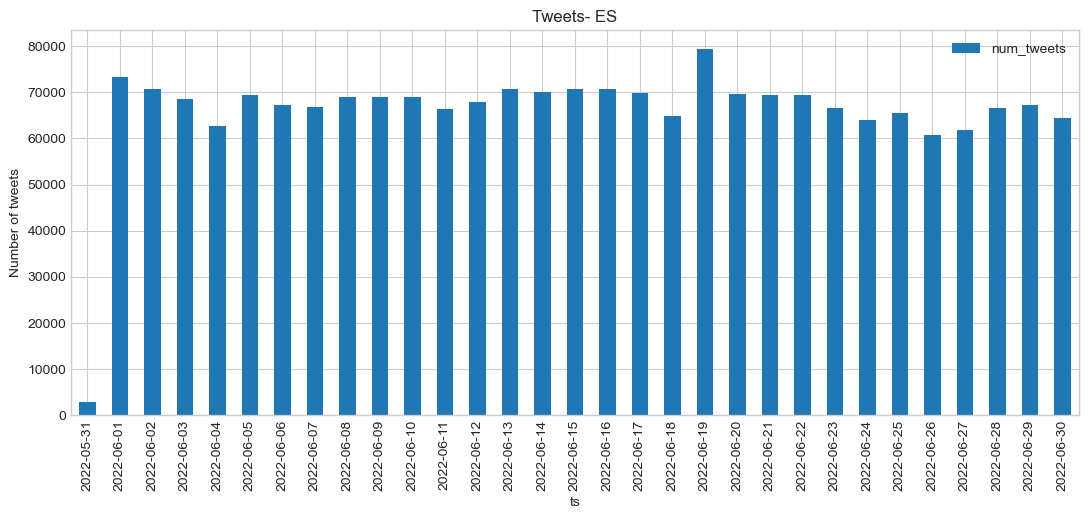

In [181]:
tweets_by_country_ES = df2[df2['cntry_cd'] == 'ES']
tweets_by_country_ES = tweets_by_country_ES.groupby([tweets_by_country_ES['ts'].dt.date]).count()[['tid']]
tweets_by_country_ES = tweets_by_country_ES.reset_index()
tweets_by_country_ES.rename(columns = {'tid':'num_tweets'}, inplace = True)
tweets_by_country_ES = tweets_by_country_ES.set_index('ts')
ax = tweets_by_country_ES.plot(kind='bar',figsize = (13,5))
ax.set_title("Tweets- ES")
ax.set_ylabel("Number of tweets")

In [183]:
files = os.listdir('C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/ES/')
directory = "C:/Users/Harshita/Exeter/Introduction to DS/Coursework/11/Working directory/ES/"

k=[]
for f in files:
    m=directory+f
    k.append(m)

df_ES = pd.concat(map(pd.read_csv, k))
df_ES=df_ES.drop_duplicates()
df_ES

temp_list = [datetime.utcfromtimestamp(i/1000) for i in df_ES['timestamp'].values]
df_ES.insert(3, "ts", temp_list, True)
df_ES=df_ES[df_ES['cntry_cd']=="ES"]

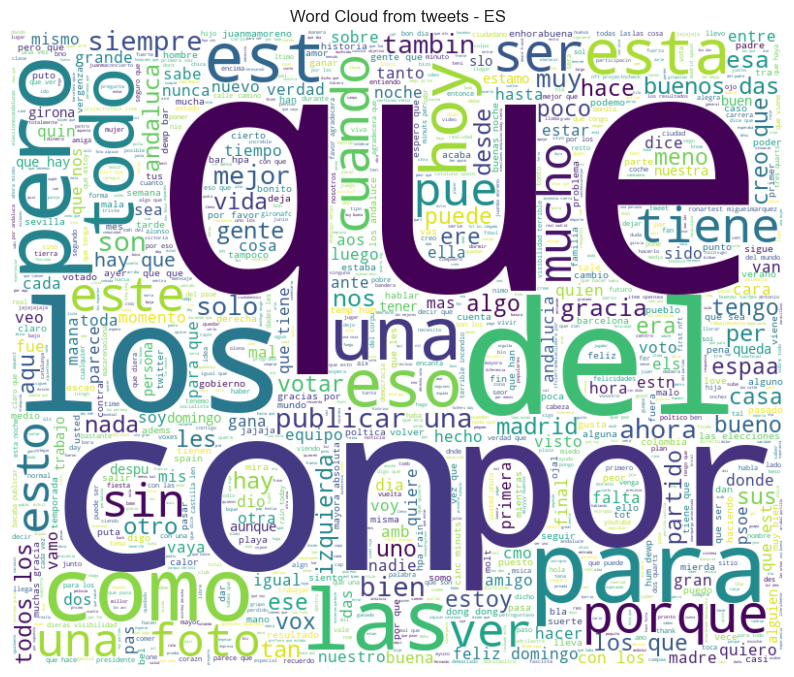

In [185]:
wc_tweets_es = list(df_ES['texts'].values)
make_wordcloud(data_list=wc_tweets_es,mask_image_path = 'twitter.png',title='Word Cloud from tweets - ES',processed=False,max_words=2000)

In [ ]:
for i in ['ES','IT','FR','BE']:
    tweets_by_country_ES = df2[df2['cntry_cd'] == 'ES']
    tweets_by_country_ES = tweets_by_country_ES.groupby([tweets_by_country_ES['ts'].dt.date]).count()[['tid']]
    tweets_by_country_ES = tweets_by_country_ES.reset_index()
    tweets_by_country_ES.rename(columns = {'tid':'num_tweets'}, inplace = True)
    tweets_by_country_ES = tweets_by_country_ES.set_index('ts')
    ax = tweets_by_country_ES.plot(kind='bar',figsize = (13,5))
    ax.set_title("Tweets- ES")
    ax.set_ylabel("Number of tweets")

In [ ]:
def make_wordcloud(data_list,mask_image_path,title,processed,max_wrd):
    if processed is False:  # Check if input data is already not a list of wrd, that is not processed already.
        raw_txt = ''.join(data_list)
        del_links = re.sub(r'http\S+', '', raw_txt) # remove http links
        del_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', del_links) # remove unicode characters
        del_chars = re.sub('[^A-Za-z ]+', '', del_unicode) # remove secial characters

        wrd = del_chars.split(" ")
        wrd = [w for w in wrd if len(w) > 2]  # ignore a, an, be, ...
        wrd = [w.lower() for w in wrd]
        wrd = [w for w in wrd if w not in STOPwrd]
    else: # if already a list of wrd, then string processing not needed.
        wrd = [w for w in data_list if len(w) > 2]  # ignore a, an, be, ...
        wrd = [w.lower() for w in wrd]
        wrd = [w for w in wrd if w not in STOPwrd]
        
    img_mask = np.array(Image.open(mask_image_path))
    wc = WordCloud(background_color="white", max_wrd=max_wrd, mask=img_mask)
    clr_string = ','.join(wrd)
    wc.generate(clr_string)

    f = plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

# Question 2b 

n = 50

text_tokens = word_tokenize(comment_words)
tokens_without_sw = [word for word in text_tokens if not word in stopwords if len(re.findall(r'\w', word))>=2]
common_words = pd.DataFrame(Counter(tokens_without_sw).most_common()[:n], columns = ['word', 'word_count'])

bubble_chart = BubbleChart(area=common_words['word_count'], bubble_spacing=0.1)
bubble_chart.collapse()

rand_colors = []
for j in range(n):
    c = "#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    rand_colors.append(c)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize = (10, 10))
bubble_chart.plot(ax, common_words['word'], colors = rand_colors)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Most frequent words')
plt.show()

In [190]:
df2['texts'][:]

0                               b'https://t.co/B3K8DCQpXg'
1                                    b'au weia! eens! b?m'
2            b'@nurse_hmsre Hay?r akepe yi aya g?nder mek'
3        b'@gigi52335676 Ci riprenderemo le colonie e a...
4        b'@rompelavabos No me consta, eso qu? es? ??? ...
                               ...                        
19101    b'@Peri_Evrim Affferim sana bee ?? https://t.c...
19102    b'SUNDAY Reset Vlog https://t.co/j2d2Ip44g1 ht...
19103    b'@trockizm98 Ot?? nie. Floh de cologne nie zn...
19104    b'@clawdialopez Mi ni?a, enseguida juntisssss ...
19105    b'@KrzysztofNorw Lepszy live z meczu niz trybu...
Name: texts, Length: 15033548, dtype: object